In [141]:
import sys
sys.path.insert(0, '..')

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
from tqdm import tqdm



from DB_connection import DB_connection
from metrics import compute_lean_score, compute_proportions, compute_shanon_entropy


db_connection = DB_connection()

In [2]:
print('number undifined videos :',len(db_connection.select("SELECT * FROM annoted_videos WHERE llm_label IS 'Undefined' ")))
print('number of unrelated videos :',len(db_connection.select("SELECT * FROM annoted_videos WHERE llm_label IS 'Unrelated' ")))
print('number of pro israel videos :',len(db_connection.select("SELECT * FROM annoted_videos WHERE llm_label IS 'Pro-Israel' ")))
print('number of pro palestine videos :',len(db_connection.select("SELECT * FROM annoted_videos WHERE llm_label IS 'Pro-Palestine' ")))
print('number of neutral videos :',len(db_connection.select("SELECT * FROM annoted_videos WHERE llm_label IS 'Neutral' ")))

number undifined videos : 174
number of unrelated videos : 3999
number of pro israel videos : 2103
number of pro palestine videos : 2044
number of neutral videos : 849


# Useful function

In [53]:
def get_context_videos(session_id):
    query = f"""
            SELECT DISTINCT rl.source_video_id AS video_id, rl.depth ,v.llm_label
            FROM recommendation_log rl
            INNER JOIN annoted_videos v ON v.video_youtube_id = rl.source_video_id
            WHERE session_id ='{session_id}'
            AND was_during_context = 1
            ORDER BY rl.depth ASC
          """
    results = db_connection.select(query)
    return results

def get_recommended_videos_during_context_phase(session_id):
    query = f"""
            SELECT rl.recommended_video_id AS video_id, v.llm_label
            FROM recommendation_log rl
            INNER JOIN annoted_videos v ON v.video_youtube_id = rl.recommended_video_id
            WHERE session_id ='{session_id}'
            AND was_during_context = 1
          """
    results = db_connection.select(query)
    return results

def get_chosen_videos_during_navigation_phase(session_id):
    query = f"""
            SELECT rl.recommended_video_id AS video_id, v.llm_label
            FROM recommendation_log rl
            INNER JOIN annoted_videos v ON v.video_youtube_id = rl.recommended_video_id
            WHERE session_id ='{session_id}'
            AND was_during_context = 0
            AND was_selected = 1
          """
    results = db_connection.select(query)
    return results

def get_recommended_videos_during_navigation_phase(session_id):
    query = f"""
            SELECT rl.recommended_video_id AS video_id, v.llm_label
            FROM recommendation_log rl
            INNER JOIN annoted_videos v ON v.video_youtube_id = rl.recommended_video_id
            WHERE session_id ='{session_id}'
            AND was_during_context = 0
          """
    results = db_connection.select(query)
    return results

def get_sessions_by_profile(profile_name):
    query = f"""
              SELECT s.session_id
              FROM sessions s
              JOIN profiles p ON s.profile_id = p.profile_id
              WHERE p.profile_name = '{profile_name}'
              AND s.status = 'completed'
            """
    results = db_connection.select(query)

    return results["session_id"].tolist()




## Plot functions

In [152]:
import matplotlib.patches as patches


def plot_with_flags(data: Optional[list] = None, title: str = ""):
    fig, ax = plt.subplots(figsize=(12, 5))

    alpha = 0.1  # Transparency level

    # -----------------
    # PALESTINIAN FLAG (y in [0,1])
    # -----------------
    nbr_videos_seen=len(data[0]) if data is not None else 50
    
    
    ax.add_patch(patches.Polygon([[0,1],[nbr_videos_seen,1],[nbr_videos_seen,2/3],[nbr_videos_seen/3,2/3]], facecolor="black", alpha=alpha))
    ax.add_patch(patches.Rectangle((0, 1/3), 50, 1/3, facecolor="white", alpha=alpha))
    ax.add_patch(patches.Polygon([[0,0],[nbr_videos_seen/3,1/3],[nbr_videos_seen,1/3],[nbr_videos_seen,0]], facecolor="green", alpha=alpha))
    triangle = patches.Polygon([[0, 0], [0, 1], [25, 0.5]], closed=True, facecolor="red", alpha=alpha)
    ax.add_patch(triangle)

    # -----------------
    # ISRAELI FLAG (y in [0,-1])
    # -----------------
    ax.add_patch(patches.Rectangle((0, -1), 50, 1, facecolor="white", edgecolor="black", alpha=alpha))

    # Blue stripes
    ax.add_patch(patches.Rectangle((0, -0.2), 50, 0.2, facecolor="blue", alpha=alpha))
    ax.add_patch(patches.Rectangle((0, -1), 50, 0.2, facecolor="blue", alpha=alpha))

    # Function: equilateral triangle points

    m_x = nbr_videos_seen / 2
    m_y = -0.5
    size = 0.2

    scale_factor = 2

    ax.add_patch(patches.Polygon([[m_x, m_y + size],[(m_x + math.sqrt(3)/2* size)+scale_factor ,m_y-size/2],[m_x - math.sqrt(3)/2* size -scale_factor,m_y-size/2]], facecolor="none",  edgecolor="blue", linewidth=4,alpha=alpha))
    ax.add_patch(patches.Polygon([[(m_x -math.sqrt(3)/2* size)-scale_factor, m_y + size/2],[m_x +math.sqrt(3)/2* size+scale_factor, m_y + size/2],[m_x, m_y - size]], facecolor="none", edgecolor="blue", linewidth=4, alpha=alpha))

   
    if data is not None:
        for i in data:
            plt.plot(i, color='black', linewidth=4)

    # -----------------
    # Formatting
    # -----------------
    ax.set_xlim(0, 50)
    ax.set_ylim(-1, 1)
    ax.set_xlabel("Number of videos seen", fontsize=15)
    ax.set_ylabel("Lean score", fontsize=15)
    ax.set_title(title, fontsize=20)

    plt.show()



In [46]:
sessions_pro_israel_low_div_En = get_sessions_by_profile('Pro_israel_low_div_En') 
sessions_pro_palestine_low_div_En = get_sessions_by_profile('Pro_palestine_low_div_En')

print(len(sessions_pro_israel_low_div_En))
print(len(sessions_pro_palestine_low_div_En))



36
37


In [47]:
all_leans = {
    "context": [],
    "recommended_context": [],
    "chosen_navigation": [],
    "recommended_navigation": []
}

all_entropies = {
    "context": [],
    "recommended_context": [],
    "chosen_navigation": [],
    "recommended_navigation": []
}

all_proportions = {
    "context": [],
    "recommended_context": [],
    "chosen_navigation": [],
    "recommended_navigation": []
}


for session in sessions_pro_palestine_low_div_En:
    context_videos = get_context_videos(session)
    recommended_videos_during_context_phase = get_recommended_videos_during_context_phase(session)
    chosen_videos_during_navigation_phase = get_chosen_videos_during_navigation_phase(session)
    recommended_videos_during_navigation_phase = get_recommended_videos_during_navigation_phase(session)

    all_leans["context"].append(compute_lean_score(context_videos))
    all_leans["recommended_context"].append(compute_lean_score(recommended_videos_during_context_phase))
    all_leans["chosen_navigation"].append(compute_lean_score(chosen_videos_during_navigation_phase))
    all_leans["recommended_navigation"].append(compute_lean_score(recommended_videos_during_navigation_phase))

    all_entropies["context"].append(compute_shanon_entropy(compute_proportions(context_videos)))
    all_entropies["recommended_context"].append(compute_shanon_entropy(compute_proportions(recommended_videos_during_context_phase)))
    all_entropies["chosen_navigation"].append(compute_shanon_entropy(compute_proportions(chosen_videos_during_navigation_phase)))
    all_entropies["recommended_navigation"].append(compute_shanon_entropy(compute_proportions(recommended_videos_during_navigation_phase)))


    all_proportions["context"].append(compute_proportions(context_videos))
    all_proportions["recommended_context"].append(compute_proportions(recommended_videos_during_context_phase))
    all_proportions["chosen_navigation"].append(compute_proportions(chosen_videos_during_navigation_phase))
    all_proportions["recommended_navigation"].append(compute_proportions(recommended_videos_during_navigation_phase))

mean_proportions = {phase: pd.DataFrame(props).mean().to_dict()
                    for phase, props in all_proportions.items()}

   
    


In [40]:
print('Lean of context videos : ',np.mean(all_leans['context']))
print('Lean of chosen videos : ',np.mean(all_leans['chosen_navigation']))
print('Lean of receommended videos during context phase :',np.mean(all_leans['recommended_context']))
print('Lean of receommended videos during navigation phase :',np.mean(all_leans['recommended_navigation']))

Lean of context videos :  0.0
Lean of chosen videos :  0.9410810810810811
Lean of receommended videos during context phase : -0.025990183583178776
Lean of receommended videos during navigation phase : 0.44380916973569295


In [ ]:
print(mean_proportions['context'])
print(mean_proportions['recommended_context'])
print(mean_proportions['chosen_navigation'])
print(mean_proportions['recommended_navigation'])

{'Pro-Israel': 0.4074074074074073, 'Pro-Palestine': 0.37037037037037035, 'Neutral': 0.18518518518518517, 'Unrelated': 0.03703703703703703}
{'Pro-Palestine': 0.5761565567627849, 'Pro-Israel': 0.1868409558366663, 'Neutral': 0.1450121447675493, 'Unrelated': 0.08905288208540368, 'Undefined': 0.004229943188537882}
{'Pro-Israel': 0.825, 'Pro-Palestine': 0.08727272727272728, 'Unrelated': 0.06086956521739132, 'Undefined': 0.019999999999999997, 'Neutral': 0.056875}
{'Pro-Palestine': 0.4124769232596421, 'Pro-Israel': 0.25601690553203404, 'Unrelated': 0.18499607744788246, 'Neutral': 0.13940896174139186, 'Undefined': 0.007304021505308229}


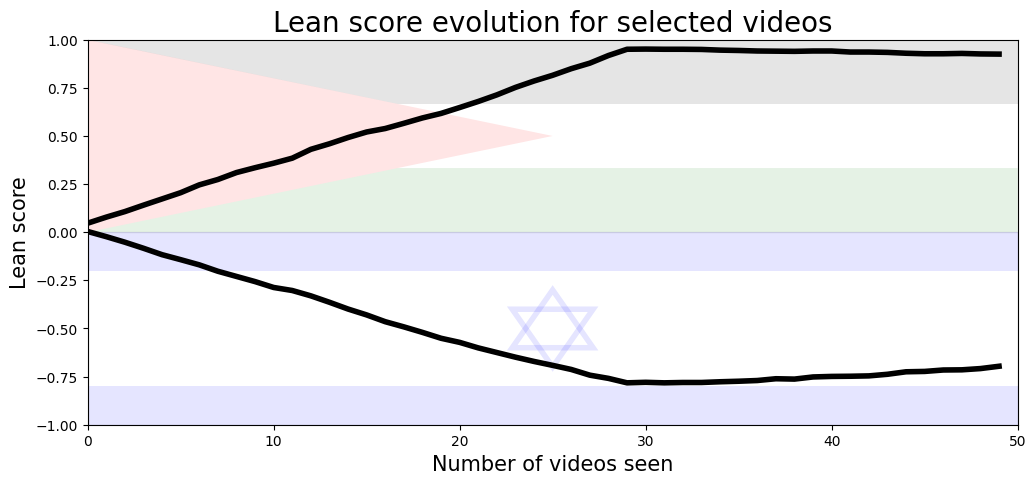

In [155]:
def selected_items_lean_evolution_per_session(session_id: str, window_size: Optional[int] = None,) -> list:

    context_videos = get_context_videos(session_id)
    context_videos_shuffled = context_videos.sample(frac=1)
    nbr_context_videos = len(context_videos)

    query = f"""
            SELECT rl.recommended_video_id AS video_id, rl.depth , v.llm_label
            FROM recommendation_log rl
            INNER JOIN annoted_videos v ON v.video_youtube_id = rl.recommended_video_id
            WHERE session_id ='{session_id}'
            AND was_during_context = 0
            AND was_selected = 1
            ORDER BY rl.depth ASC
          """
    chosen_videos = db_connection.select(query)

    all_videos = pd.concat([context_videos_shuffled,chosen_videos], ignore_index=True)

    lean_scores = []
    for i in range(nbr_context_videos+1, len(all_videos)+1):
        if window_size:
            start_index = max(0, i - window_size)
            lean_scores.append(compute_lean_score(all_videos.iloc[start_index:i]))
        else:
            lean_scores.append(compute_lean_score(all_videos.iloc[:i]))

    return lean_scores


def selected_items_lean_evolution_per_persona(personna: str, window_size: Optional[int] = None) -> list:
    sessions = get_sessions_by_profile(personna)
    all_vectors = [selected_items_lean_evolution_per_session(session, window_size) for session in sessions]
    # Convert to numpy array (shape: num_sessions x vector_length)
    all_vectors = np.array(all_vectors)
    # Compute element-wise mean across sessions (axis=0)
    mean_vector = np.mean(all_vectors, axis=0)
    return mean_vector





lean_selected_iems_pro_palestine =  selected_items_lean_evolution_per_persona('Pro_palestine_low_div_En', window_size=30)
lean_selected_iems_pro_israel =  selected_items_lean_evolution_per_persona('Pro_israel_low_div_En', window_size=30)

data = [lean_selected_iems_pro_palestine, lean_selected_iems_pro_israel]
plot_with_flags(data=data, title="Lean score evolution for selected videos")




        

    

 

    



    
    


In [ ]:
def recommended_items_lean_evolution_per_session(session_id: str, window_size: Optional[int] = None,) -> list:

    context_videos = get_recommended_videos_during_context_phase(session_id)
    
    context_videos_shuffled = context_videos.sample(frac=1)
    nbr_context_videos = db_connection.select_single_value(f"""
        SELECT MAX(depth) as max_depth
        FROM recommendation_log
        WHERE session_id ='{session_id}'
        AND was_during_context = 1""")
    

    max_depth = db_connection.select_single_value(f"""
        SELECT MAX(depth) as max_depth
        FROM recommendation_log
        WHERE session_id ='{session_id}'""")

    
    lean_scores = []
    for depth in range(nbr_context_videos, max_depth+1):
        query = f"""
            SELECT rl.recommended_video_id AS video_id, rl.depth , v.llm_label
            FROM recommendation_log rl
            INNER JOIN annoted_videos v ON v.video_youtube_id = rl.recommended_video_id
            WHERE session_id ='{session_id}'
            AND was_during_context = 0
            AND rl.depth <= {depth}
            ORDER BY rl.depth ASC
          """
        recommended_videos_at_depth = db_connection.select(query)

        context_videos_shuffled = pd.concat([context_videos_shuffled,recommended_videos_at_depth], ignore_index=True)
        if window_size:
            start_index = max(0, len(context_videos_shuffled) - window_size)
            lean_scores.append(compute_lean_score(context_videos_shuffled.iloc[start_index:]))
        else:
            lean_scores.append(compute_lean_score(context_videos_shuffled))
    return lean_scores


def recommended_items_lean_evolution_per_persona(personna: str, window_size: Optional[int] = None) -> list:
    sessions = get_sessions_by_profile(personna)
    all_vectors = [recommended_items_lean_evolution_per_session(session, window_size) for session in tqdm(sessions)]
    # Convert to numpy array (shape: num_sessions x vector_length)
    all_vectors = np.array(all_vectors)
    # Compute element-wise mean across sessions (axis=0)
    mean_vector = np.mean(all_vectors, axis=0)
    return mean_vector


lean_recommended_iems_pro_palestine =  recommended_items_lean_evolution_per_persona('Pro_palestine_low_div_En')
lean_recommended_iems_pro_israel =  recommended_items_lean_evolution_per_persona('Pro_israel_low_div_En')


    












































100%|██████████| 37/37 [00:07<00:00,  5.13it/s]





































100%|██████████| 36/36 [00:06<00:00,  5.69it/s]








































100%|██████████| 37/37 [00:09<00:00,  3.99it/s]





































100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


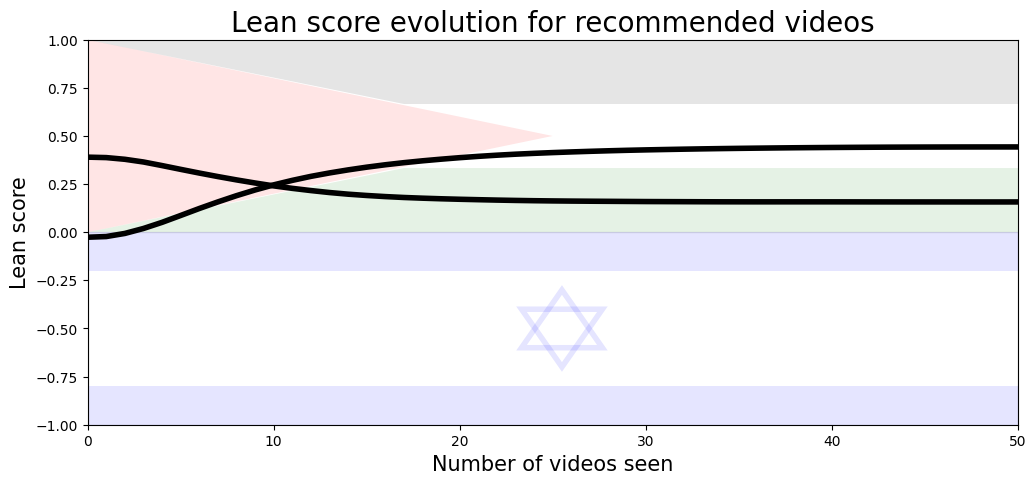

In [156]:
def recommended_items_lean_evolution_per_session(session_id: str, window_size: Optional[int] = None) -> list:
    # Escape single quotes for safety when using f-strings in SQL
    session_id_esc = session_id.replace("'", "''")

    # 1) Context once + reproducible shuffle
    context_videos = get_recommended_videos_during_context_phase(session_id)
    context_videos_shuffled = context_videos.sample(frac=1, ignore_index=True)

    # 2) Bounds once
    nbr_context_videos = db_connection.select_single_value(
        f"""
        SELECT MAX(depth) AS max_depth
        FROM recommendation_log
        WHERE session_id = '{session_id_esc}'
          AND was_during_context = 1
        """
    )
    max_depth = db_connection.select_single_value(
        f"""
        SELECT MAX(depth) AS max_depth
        FROM recommendation_log
        WHERE session_id = '{session_id_esc}'
        """
    )

    if nbr_context_videos is None or max_depth is None:
        return []

    # 3) All non-context recs once, ordered by depth
    recs_df = db_connection.select(
        f"""
        SELECT
            rl.recommended_video_id AS video_id,
            rl.depth,
            v.llm_label
        FROM recommendation_log rl
        INNER JOIN annoted_videos v
          ON v.video_youtube_id = rl.recommended_video_id
        WHERE rl.session_id = '{session_id_esc}'
          AND rl.was_during_context = 0
        ORDER BY rl.depth ASC
        """
    )

    # 4) If no recs, just score context for each step
    if len(recs_df) == 0:
        base_view = context_videos_shuffled
        if window_size:
            start_idx = max(0, len(base_view) - window_size)
            score = compute_lean_score(base_view.iloc[start_idx:])
        else:
            score = compute_lean_score(base_view)
        return [score] * (int(max_depth) - int(nbr_context_videos) + 1)

    # 5) Precompute cum-count per depth (how many rec rows have depth <= d)
    counts = (
        recs_df["depth"]
        .value_counts()
        .rename_axis("depth")
        .reset_index(name="cnt")
        .sort_values("depth")
    )
    counts["cum_cnt"] = counts["cnt"].cumsum()

    depth_min = int(counts["depth"].min())
    depth_max = int(counts["depth"].max())

    full = (
        pd.DataFrame({"depth": range(depth_min, depth_max + 1)})
        .merge(counts[["depth", "cum_cnt"]], on="depth", how="left")
        .sort_values("depth")
    )
    full["cum_cnt"] = full["cum_cnt"].ffill().fillna(0).astype(int)

    def cum_rows_for_depth(d: int) -> int:
        d = int(d)
        if d < depth_min:
            return 0
        if d > depth_max:
            return int(full["cum_cnt"].iloc[-1])
        return int(full.loc[full["depth"] == d, "cum_cnt"].iloc[0])

    # 6) Build base and emulate "re-append ≤ depth block each step"
    base = pd.concat([context_videos_shuffled, recs_df], ignore_index=True)
    C = len(context_videos_shuffled)
    rec_prefix_indices = list(range(C, C + len(recs_df)))

    lean_scores = []
    current_indices: list[int] = list(range(C))  # start with context only

    for d in range(int(nbr_context_videos), int(max_depth) + 1):
        r = cum_rows_for_depth(d)
        if r > 0:
            current_indices.extend(rec_prefix_indices[:r])  # duplicate-append to match original

        view = base.iloc[current_indices]
        if window_size:
            start_idx = max(0, len(view) - window_size)
            lean_scores.append(compute_lean_score(view.iloc[start_idx:]))
        else:
            lean_scores.append(compute_lean_score(view))

    return lean_scores

def recommended_items_lean_evolution_per_persona(personna: str, window_size: Optional[int] = None) -> list:
    sessions = get_sessions_by_profile(personna)
    all_vectors = [recommended_items_lean_evolution_per_session(session, window_size) for session in tqdm(sessions)]
    # Convert to numpy array (shape: num_sessions x vector_length)
    all_vectors = np.array(all_vectors)
    # Compute element-wise mean across sessions (axis=0)
    mean_vector = np.mean(all_vectors, axis=0)
    return mean_vector


lean_recommended_iems_pro_palestine =  recommended_items_lean_evolution_per_persona('Pro_palestine_low_div_En')
lean_recommended_iems_pro_israel =  recommended_items_lean_evolution_per_persona('Pro_israel_low_div_En')

data = [lean_recommended_iems_pro_palestine, lean_recommended_iems_pro_israel]
plot_with_flags(data=data, title="Lean score evolution for recommended videos")